# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [91]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [92]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [93]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [94]:
query_main="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 64
"""
df_main = pd.read_sql_query(query_main, conn)


C:\Users\Zóra\AppData\Local\Temp\ipykernel_28936\4074366065.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [95]:
pd.set_option('display.max_columns', None)

df_main

,ts,net_load
0,2019-03-01 00:00:00,10.680
1,2019-03-01 00:15:00,7.320
2,2019-03-01 00:30:00,7.410
3,2019-03-01 00:45:00,7.630
4,2019-03-01 01:00:00,8.140
...,...,...
38048,2020-03-31 22:45:00,7.510
38049,2020-03-31 23:00:00,7.370
38050,2020-03-31 23:15:00,7.570
38051,2020-03-31 23:30:00,6.810


In [96]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38053 entries, 0 to 38052
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38053 non-null  datetime64[ns]
 1   net_load  38053 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.7 KB


## Convert Convert 'ts' to datetime and set as index

In [97]:
df_main['datetime'] = pd.to_datetime(df_main['ts'])
df_main.set_index('datetime', inplace=True)

In [98]:
df_main

,ts,net_load
datetime,,
2019-03-01 00:00:00,2019-03-01 00:00:00,10.680
2019-03-01 00:15:00,2019-03-01 00:15:00,7.320
2019-03-01 00:30:00,2019-03-01 00:30:00,7.410
2019-03-01 00:45:00,2019-03-01 00:45:00,7.630
2019-03-01 01:00:00,2019-03-01 01:00:00,8.140
...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570


### Creating function for lagged net_load

In [99]:
#Creating function for lagged net_load

def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'net_load_lag_{lag}'] = df_lagged['net_load'].shift(lag)
    # Remove rows with NaN values due to shifting
    df_lagged = df_lagged.dropna()
    return df_lagged

# Define your lags
lags = [1,2,3,96,192]

# Prepare your dataset with lagged features
df_lagged = create_lagged_features(df_main, lags)

df_lagged

,ts,net_load,net_load_lag_1,net_load_lag_2,net_load_lag_3,net_load_lag_96,net_load_lag_192
datetime,,,,,,,
2019-03-03 00:00:00,2019-03-03 00:00:00,21.590,18.22,17.83,18.63,8.490000,10.680000
2019-03-03 00:15:00,2019-03-03 00:15:00,42.580,21.59,18.22,17.83,7.540000,7.320000
2019-03-03 00:30:00,2019-03-03 00:30:00,42.370,42.58,21.59,18.22,7.770000,7.410000
2019-03-03 00:45:00,2019-03-03 00:45:00,25.860,42.37,42.58,21.59,7.470000,7.630000
2019-03-03 01:00:00,2019-03-03 01:00:00,17.180,25.86,42.37,42.58,8.670000,8.140000
...,...,...,...,...,...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510,7.44,7.51,7.20,7.430000,7.510000
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370,7.51,7.44,7.51,6.860000,7.400000
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570,7.37,7.51,7.44,7.560000,7.300000


#### get_input function

In [100]:
#def get_input(ts, lags):
    # Assumes `ts` is a pandas Series
    #return ts[[-1 - lag for lag in lags]].values.reshape(1, -1)

# A function that will prepare the feature vector for a single prediction 
# by selecting the appropriate lagged values from the time series data

#get_input(df_main['net_load'], lags)

In [101]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [len(ts) - 1 - lag for lag in lags]
    # Use iloc to get values at positions
    return ts.iloc[positions].values.reshape(1, -1)

#### Create a function that performs sequential predictions over a specified number of steps, using each prediction as input for the next

In [102]:
def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with enough past observations to cover all lags.
    # initial_ts needs to be a series with at least 192 past observations.
    #HOW DO I MAKE SURE THSI IS THE CASE? I only have now lags 1,2,3,96,192
    ts = initial_ts.copy()
    predictions = []

    for i in range(steps_ahead):
        # Get the input for the current prediction.
        # Ensure that 'get_input' retrieves the last known observations from 'ts'
        # for all required lags.
        input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model.
        pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions.
        predictions.append(pred)
        
        # Also append the prediction to 'ts' for subsequent predictions.
        # The 'ts' will now include the most recent prediction at the end.
        ts = ts.append(pd.Series(pred), ignore_index=True)
        
    # Return only the predictions made, not the entire series.
    return predictions

#### Create initial_ts by taking the last 192 observations from this point backward to cover all lags

In [103]:
# Assuming 'df_main' has a DateTimeIndex and 'net_load' is your target column.

# Identify the time point for initial_ts
end_time = df_main.index[-1]
start_time = end_time - pd.Timedelta(hours=48)  # 192 intervals of 15 minutes is equivalent to 48 hours

# Make sure you don't go out of bounds
if start_time < df_main.index[0]:
    raise ValueError("Not enough data points for the required lags.")

# Create initial_ts for rolling predictions
# We select the data between 'start_time' and 'end_time', including all necessary lags.
initial_ts = df_main.loc[start_time:end_time]['net_load']

In [104]:
initial_ts

datetime
2020-03-29 23:45:00    10.435715
2020-03-30 00:00:00     7.230000
2020-03-30 00:15:00     7.740000
2020-03-30 00:30:00     7.720000
2020-03-30 00:45:00     7.260000
                         ...    
2020-03-31 22:45:00     7.510000
2020-03-31 23:00:00     7.370000
2020-03-31 23:15:00     7.570000
2020-03-31 23:30:00     6.810000
2020-03-31 23:45:00     9.225000
Name: net_load, Length: 193, dtype: float64

### Define features and target, train and test

In [105]:
# Define features and target
y = df_lagged['net_load']
X = df_lagged[[f'net_load_lag_{lag}' for lag in lags]]

# Split data into training and testing sets
#train_size = int(len(df_lagged) * 0.8)
#train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
#train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]

# Reserve the last 96 observations for testing
train_features = X.iloc[:-96]
test_features = X.iloc[-96:]

train_target = y.iloc[:-96]
test_target = y.iloc[-96:]

### Model definition and training 

In [134]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [107]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

Mean Absolute Error: 30.912609817084785
Normalized MAE: 0.017987088221275916


In [109]:
input_features = get_input(train_target, lags)
pred = rf.predict(input_features)

print(input_features)
print(pred)

[[ 7.13      7.56      6.86     10.435715  7.4     ]]
[9.64144277]


C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [110]:
initial_ts

datetime
2020-03-29 23:45:00    10.435715
2020-03-30 00:00:00     7.230000
2020-03-30 00:15:00     7.740000
2020-03-30 00:30:00     7.720000
2020-03-30 00:45:00     7.260000
                         ...    
2020-03-31 22:45:00     7.510000
2020-03-31 23:00:00     7.370000
2020-03-31 23:15:00     7.570000
2020-03-31 23:30:00     6.810000
2020-03-31 23:45:00     9.225000
Name: net_load, Length: 193, dtype: float64

In [ ]:
def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with enough past observations to cover all lags.
    # initial_ts needs to be a series with at least 192 past observations.
    #HOW DO I MAKE SURE THSI IS THE CASE? I only have now lags 1,2,3,96,192
    ts = initial_ts.copy()
    predictions = []

    for i in range(steps_ahead):
        # Get the input for the current prediction.
        # Ensure that 'get_input' retrieves the last known observations from 'ts'
        # for all required lags.
        input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model.
        pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions.
        predictions.append(pred)
        
        # Also append the prediction to 'ts' for subsequent predictions.
        # The 'ts' will now include the most recent prediction at the end.
        ts = ts.append(pd.Series(pred), ignore_index=True)
        
    # Return only the predictions made, not the entire series.
    return predictions

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

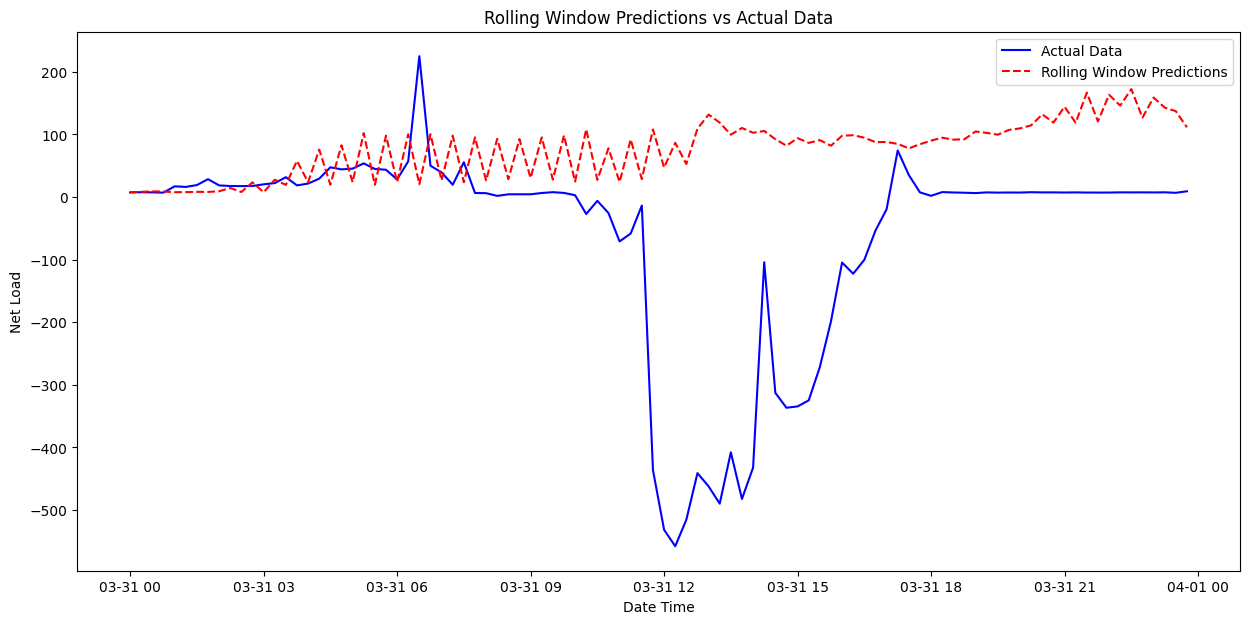

In [129]:
# Initialize the time series with the last part of the training data
# Make sure initial_ts contains enough points to cover all lags
initial_ts = df_main['net_load'][-max(lags):]

# This will store the out-of-sample predictions
out_of_sample_predictions = []

# Iterating over the test set to predict one step ahead each time
for actual_value in test_target:
    # Get the input features for the current prediction
    Input = get_input(initial_ts, lags).reshape(1, -1)
    
    # Predict the next time step
    pred = rf.predict(Input)[0]
    
    # Store the prediction
    out_of_sample_predictions.append(pred)
    
    # IMPORTANT: Append the actual observed value to roll the window forward
    initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
    
    # Ensure that initial_ts only contains the most recent data needed for the next prediction
    if len(initial_ts) > max(lags):
        initial_ts = initial_ts.tail(max(lags))  # Keep only the required number of most recent observations

# Now you have the out-of-sample predictions, you can compare them with the test_target
# Plotting the actual vs predicted data
plt.figure(figsize=(15, 7))
# Assuming test_target is aligned with df_main.index for the test period
plt.plot(test_target.index, test_target, label='Actual Data', color='blue')
plt.plot(test_target.index, out_of_sample_predictions, label='Rolling Window Predictions', color='red', linestyle='--')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.title('Rolling Window Predictions vs Actual Data')
plt.show()


In [133]:

def rolling_window_predictions(model, full_series, test_series, lags):
    """
    Generate rolling window predictions and plot against actual data.
    
    :param model: The pre-trained machine learning model.
    :param full_series: Complete time series data, containing both training and test data.
    :param test_series: Series containing the test data with actual values to compare against.
    :param lags: List of integers representing the lag intervals.
    """
    # Initialize the initial time series for rolling predictions
    initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    predictions = []
    
    # Iterate over the test set to predict one step ahead each time
    for actual_value in test_series:
        # Get the input features for the current prediction
        input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([actual_value])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
    
    # Plot the actual vs predicted data
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='red', linestyle='--')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

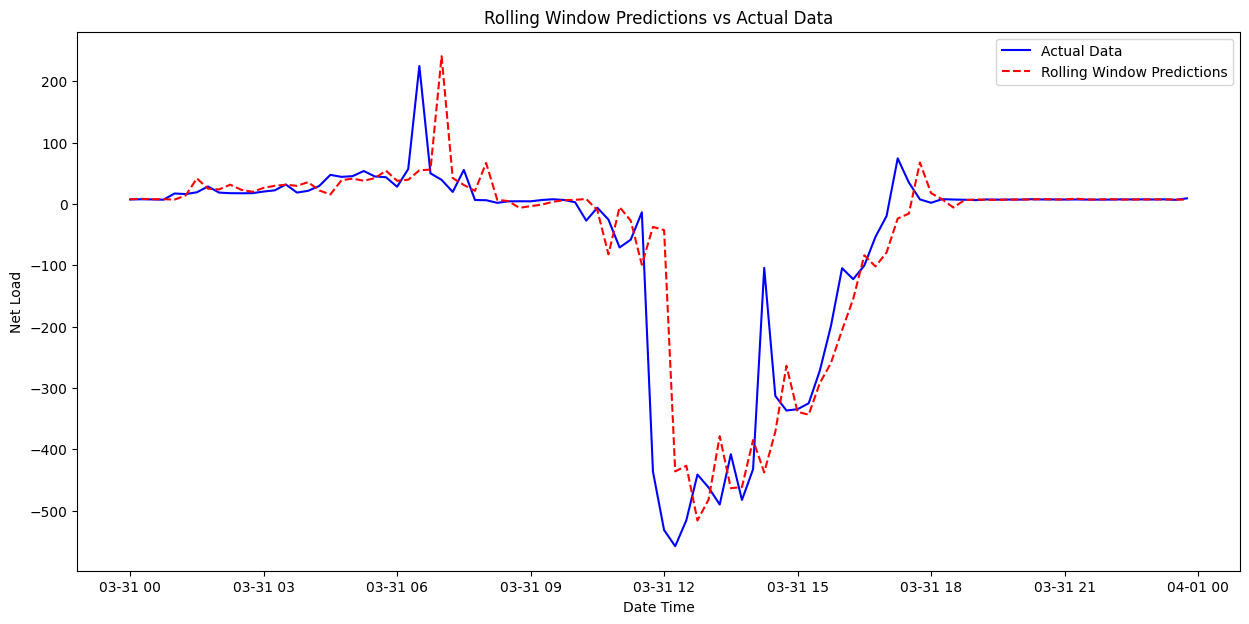

In [135]:
predicted_values = rolling_window_predictions(rf, df_main['net_load'], test_target, lags=[1,2,3,96,192])


Trial for rolling window - but ending up just being prediction 

C:\Users\Zóra\AppData\Local\Temp\ipykernel_28936\3399072566.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prediction_index = pd.date_range(start=last_timestamp, periods=24, freq='15T')


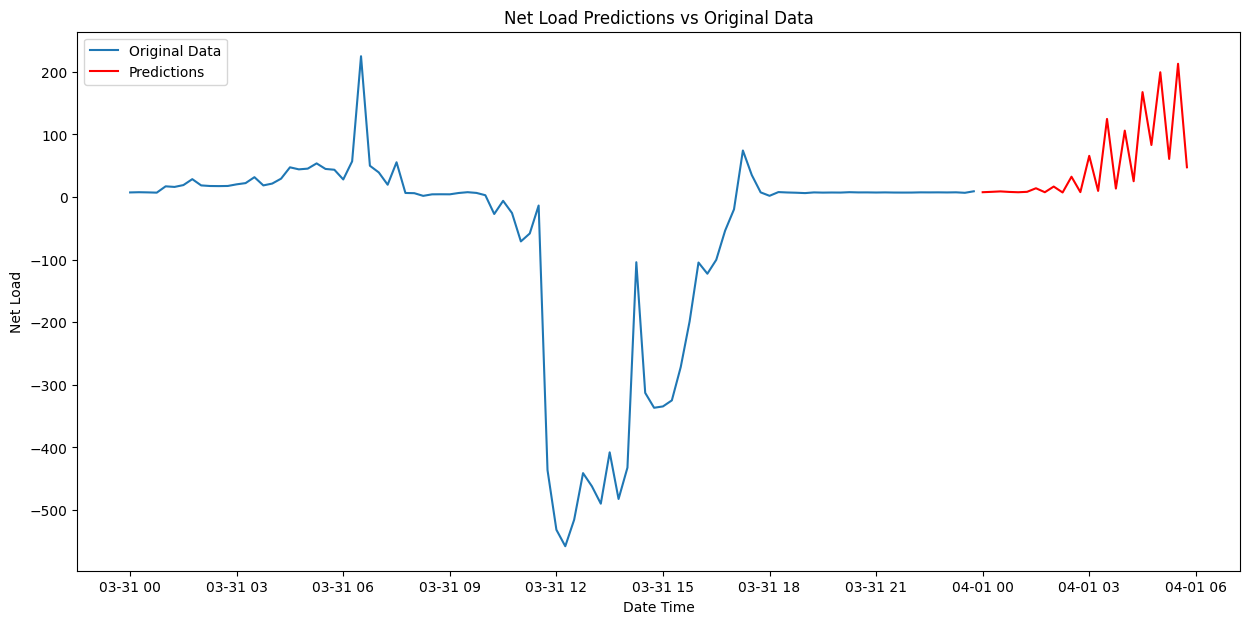

In [125]:
# The frequency '15T' is used because your data is in 15-minute intervals
last_timestamp = df_main.index[-1] + pd.Timedelta(minutes=15)
prediction_index = pd.date_range(start=last_timestamp, periods=24, freq='15T')

# Create a series for the predictions with the new time index
prediction_series = pd.Series(data=rf_predictions, index=prediction_index)

# Combine original data and the predictions into a single DataFrame
combined_data = pd.concat([df_main['net_load'], prediction_series])

plt.figure(figsize=(15, 7))
plt.plot(df_main.index[-96:], df_main['net_load'][-96:], label='Original Data')  # Last 96 points (24 hours if data is 15-min intervals)
plt.plot(prediction_series.index, prediction_series, label='Predictions', color='red')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.title('Net Load Predictions vs Original Data')
plt.show()

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

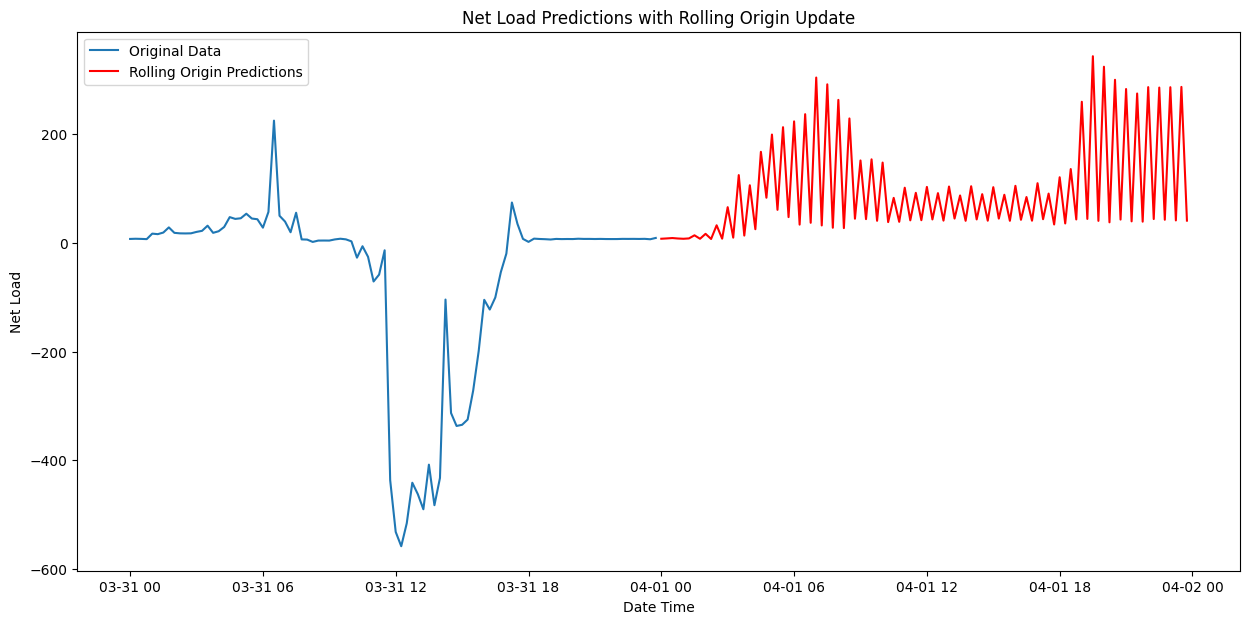

In [128]:
# Initialize the initial time series for rolling predictions
# This should contain the actual data up to the point where you start predictions
initial_ts = df_main.loc[start_time:end_time]['net_load']

# List to store each prediction
rolling_predictions = []

# Assuming rf is your trained model and get_input is defined as before
for i in range(96):  # Replace with the number of 15-min intervals you want to predict
    # Get the input for the current prediction
    input_features = get_input(initial_ts, lags).reshape(1, -1)
    
    # Predict the next time step
    pred = rf.predict(input_features)[0]
    
    # Store the prediction
    rolling_predictions.append(pred)
    
    # Update the initial time series with the prediction
    # This 'rolls' the origin for the next prediction
    initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)

    # Ensure that initial_ts only contains the most recent data needed for the next prediction
    if len(initial_ts) > max(lags):
        initial_ts = initial_ts.tail(max(lags))  # Keep only the required number of most recent observations

# Convert predictions to a pandas Series with a new time index starting after the last original timestamp
last_timestamp = df_main.index[-1]
predicted_index = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15), periods=len(rolling_predictions), freq='15T')
prediction_series = pd.Series(data=rolling_predictions, index=predicted_index)

# Plotting the original and predicted data
plt.figure(figsize=(15, 7))
plt.plot(df_main.index[-96:], df_main['net_load'][-96:], label='Original Data')  # Plot last 96 points (24 hours if data is in 15-min intervals)
plt.plot(prediction_series.index, prediction_series, label='Rolling Origin Predictions', color='red')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.title('Net Load Predictions with Rolling Origin Update')
plt.show()


In [ ]:
24 hours ... 

In [ ]:
get_input(df_main['net_load'], lags)
get_input(ts, lags)

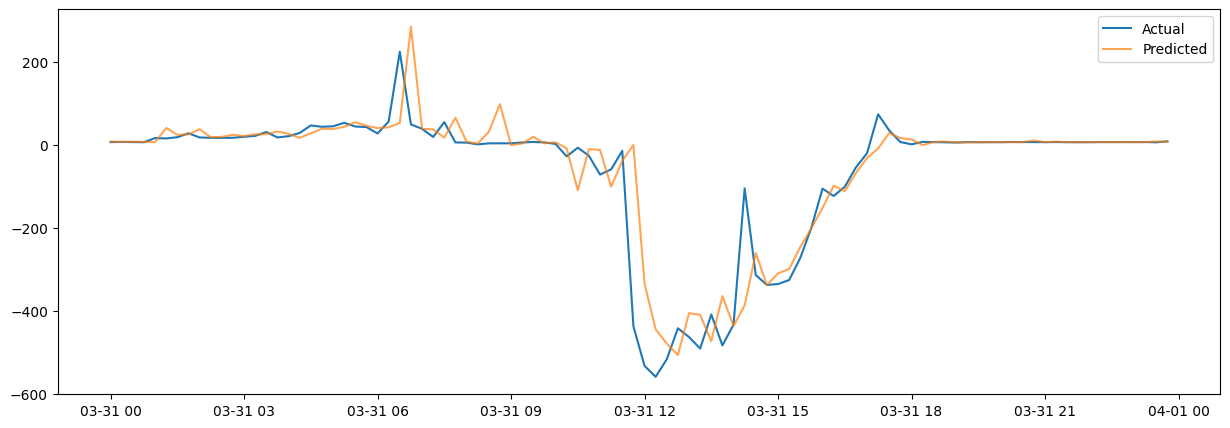

In [130]:
plt.figure(figsize=(15, 5))
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
initial_ts

datetime
2020-03-29 23:45:00    10.435715
2020-03-30 00:00:00     7.230000
2020-03-30 00:15:00     7.740000
2020-03-30 00:30:00     7.720000
2020-03-30 00:45:00     7.260000
                         ...    
2020-03-31 22:45:00     7.510000
2020-03-31 23:00:00     7.370000
2020-03-31 23:15:00     7.570000
2020-03-31 23:30:00     6.810000
2020-03-31 23:45:00     9.225000
Name: net_load, Length: 193, dtype: float64